In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [3]:
if not GEMINI_API_KEY:
    raise ValueError ("API_KEY is missing your .env file")
os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

In [5]:
## Gemini
chat_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
# chat_llm = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")

In [324]:
## Groq

chat_llm = ChatGroq(model="openai/gpt-oss-120b")

In [6]:
chat_llm.invoke("Hello, How are you?").content

'Hello! I am doing well, thank you for asking. I am a large language model, trained by Google. How can I help you today?'

In [7]:
from typing_extensions import TypedDict, Annotated
import operator

In [8]:
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

In [9]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
# u can add many number of messages in a list. For Eg: ["Hi", "How are you?"]

In [10]:
{
    "messages": [HumanMessage(content="Hi, This is Sharan. Say hello in a detail.")]
}

{'messages': [HumanMessage(content='Hi, This is Sharan. Say hello in a detail.', additional_kwargs={}, response_metadata={})]}

In [11]:
def llm_call(state:GraphState) -> dict:
    """Call the llm using conversation messages and append AI response"""
    response = chat_llm.invoke(state["messages"])
    return {"messages": [response]}

In [12]:
def token_counter(state:GraphState) -> dict:
    """Count tokens (simple word count) in the last AI message."""
    last_msg = state["messages"][-1]
    text = last_msg.content
    token_number = len(text.split())
    Summary = f"Total token number in the generated answer (word count) is {token_number}"
    return {"messages": [AIMessage(content=Summary)]}

In [13]:
from langgraph.graph import StateGraph

In [14]:
builder = StateGraph(GraphState)

In [15]:
builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [16]:
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [17]:
app = builder.compile()

In [18]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

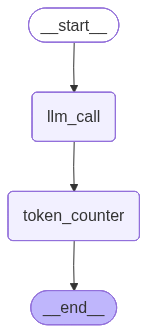

In [19]:
from IPython.core.display import Image
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
# Call this above graph flow
result = app.invoke({"messages": [HumanMessage(content="Hi, This is Sharan. Say hello in a detail.")]})

In [21]:
result

{'messages': [HumanMessage(content='Hi, This is Sharan. Say hello in a detail.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello Sharan!\n\nIt\'s wonderful to hear from you. I hope this message finds you well.\n\nAs an AI, I don\'t have a physical presence or the ability to express emotions in the way a human does. However, I can certainly convey a **warm and enthusiastic greeting** to you.\n\nThink of my "hello" as a digital handshake, a friendly nod across the vast expanse of the internet, and a clear signal that I\'m here and ready to engage with you.\n\nHere\'s a more detailed breakdown of what my "hello" signifies:\n\n*   **Acknowledgement and Recognition:** It\'s my way of saying, "I see you, Sharan! Your presence has been registered."\n*   **Readiness to Interact:** It implies that I\'ve processed your introduction and am now prepared to listen, understand, and respond to whatever you have to say or ask.\n*   **Openness and Availability:** My hello is an 

In [22]:
for i in result["messages"]:
    print(type(i).__name__, ":", i.content)

HumanMessage : Hi, This is Sharan. Say hello in a detail.
AIMessage : Hello Sharan!

It's wonderful to hear from you. I hope this message finds you well.

As an AI, I don't have a physical presence or the ability to express emotions in the way a human does. However, I can certainly convey a **warm and enthusiastic greeting** to you.

Think of my "hello" as a digital handshake, a friendly nod across the vast expanse of the internet, and a clear signal that I'm here and ready to engage with you.

Here's a more detailed breakdown of what my "hello" signifies:

*   **Acknowledgement and Recognition:** It's my way of saying, "I see you, Sharan! Your presence has been registered."
*   **Readiness to Interact:** It implies that I've processed your introduction and am now prepared to listen, understand, and respond to whatever you have to say or ask.
*   **Openness and Availability:** My hello is an invitation for you to proceed. It signifies that I'm ready to dedicate my computational resourc

In [23]:
chat_llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-2.5-flash-lite', client=<google.genai.client.Client object at 0x0000024238BD3BF0>, default_metadata=(), model_kwargs={})

### WikiPedia Tool

In [24]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [25]:
api_wrapper = WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=500)

In [26]:
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [27]:
wiki_tool.run({"query": "what is Generative AI?"})

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence, also known as generative AI or GenAI, is a subfield of artificial intelligence that uses generative models to generate text, images, videos, audio, software code or other forms of data. These models learn the underlying patterns and structures of their training data, and use them to generate new data in response to input, which often takes the form of natural language prompts.\nThe prevalence of generative AI to'

## TOOLS

##### What is Tool?: Its any service or application that can be used to perform a specific task.

##### What is Agent? : It is a program that can use tools to perform a specific task.

##### Agentic Flow = LLM + Tool Calling + Memory + Planning


### 1. Tavily Tool

In [28]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [29]:
if not TAVILY_API_KEY:
    raise ValueError ("API_KEY is missing your .env file")
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [30]:
TAVILY_API_KEY

'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'

In [31]:
tavily_tool = TavilySearchResults(TAVILY_API_KEY=TAVILY_API_KEY)

C:\Users\kumar\AppData\Local\Temp\ipykernel_5740\3927083772.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(TAVILY_API_KEY=TAVILY_API_KEY)


In [32]:
tavily_tool.invoke({"query": "How is the job market for software engineers in 2026?"})

[{'title': 'Software Engineering Job Market Outlook for 2026 - Final Round AI',
  'url': 'https://www.finalroundai.com/blog/software-engineering-job-market-2026',
  'content': "## Bottom Line\n\nSo, is pursuing a career in software engineering still a smart move in 2026? Breaking into the field is harder than it was a few years ago, and you are competing with more people for fewer entry-level positions.\n\nBut the financial case is still strong. Software engineers still make significantly more than most other careers. The median salary for a software engineer in the US in 2026 is $130,000.\n\nNow, to get the right job, you need to continuously level up your skills. If you genuinely enjoy problem-solving, this is a great career.\n\nBuild projects. Network with people in the industry. That’s the open secret to getting a job in 2026.\n\nDevelop expertise in valuable areas rather than being a generalist who's mediocre at everything. [...] The US Bureau of Labor Statistics still expects sof

### 2. DuckDuckGo Search Tool

In [33]:
from langchain_community.tools import DuckDuckGoSearchResults
duckgo_search = DuckDuckGoSearchResults()

In [34]:
duckgo_search.invoke("What is the news for iphone 17 release date?")

Impersonate 'chrome_114' does not exist, using 'random'


'snippet: The iPhone 17 uses the Apple A19 SoC. It incorporates the new Apple-designed N1 networking chip, part of a trend by Apple to reduce reliance on Broadcom and third-party chip suppliers.[6] The N1 supports Wi-Fi 7, Bluetooth 6.0, and Thread., title: iPhone 17 - Wikipedia, link: https://en.wikipedia.org/wiki/IPhone_17, snippet: iPhone 17 features the innovative Center Stage front camera, a bigger and brighter new display with ProMotion, and the A19 chip for improved performance., title: Apple debuts iPhone 17 - Apple, link: https://www.apple.com/newsroom/2025/09/apple-debuts-iphone-17/, snippet: Apple iPhone 17 Pro Release Date Latest News : What To Expect When And Where., title: Google News - News about iPhone 17 • Apple - Overview, link: https://news.google.com/stories/CAAqNggKIjBDQklTSGpvSmMzUnZjbmt0TXpZd1NoRUtEd2lOOU9hbkR4SFJvS21hY2ZVdXVDZ0FQAQ?hl=en-IN&gl=IN&ceid=IN:en, snippet: With its lower price point, high-end camera, upgraded display technology, and A19 chip, the iPho

### 3. Serper Tool

In [35]:
import os
import pprint
SERPER_API_KEY = os.getenv("SERPER_API_KEY")

In [36]:
if not SERPER_API_KEY:
    raise ValueError ("API_KEY is missing your .env file")
os.environ["TAVILY_API_KEY"] = SERPER_API_KEY

In [37]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper_tool = GoogleSerperAPIWrapper()

In [38]:
serper_tool.run("Who is Narendra Modi?")

"Narendra Modi is the 14th prime minister of India. His Hindu nationalist policies and some of his economic reforms have proved controversial ... Mr. Modi is the third child born to Damodardas Modi and Hiraba Modi. Mr. Modi comes from a family of humble origins and modest means. Prime Minister of India · Experience: Government of India · Education: Gujarat University · Location: Delhi. View Narendra Modi's profile on LinkedIn, ... The first ever Prime Minister to be born after Independence, Shri Modi has previously served as the Prime Minister of India from 2014 to 2019. Narendra Modi \U000f188f. Prime Minister of India. \U000f17b4 Politician. Shri Narendra Modi was sworn-in as India's Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary ... 100M followers · 0 following · 1181 posts · @narendramodi: “Prime Minister of India ” Ten years after becoming prime minister, Narendra Modi is aiming for a historic third term - what make

### 4. Youtube Search Tool

In [39]:
from langchain_community.tools import YouTubeSearchTool

In [40]:
youtube_search_tool = YouTubeSearchTool()

In [41]:
youtube_search_tool.description

'search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional'

In [42]:
youtube_search_tool.run("Sharan,5")

"['https://www.youtube.com/watch?v=j-TOQyqbwRA&pp=ygUGU2hhcmFu', 'https://www.youtube.com/watch?v=oGSwhDzSgkw&pp=ygUGU2hhcmFu', 'https://www.youtube.com/watch?v=7oDshjZzW98&pp=ygUGU2hhcmFu', 'https://www.youtube.com/watch?v=pN-oI_-lR6M&pp=ygUGU2hhcmFu', 'https://www.youtube.com/watch?v=RNMI0uqz5-8&pp=ygUGU2hhcmFu']"

#### 5. Custom Tool Creation - Tool Decorators

In [43]:
def multiply(a:int, b:int)->int:
    return a*b

In [44]:
multiply(2,5) # its a just function call

10

##### Converting Custom Tool def function to Tool generator

In [45]:
from langchain.tools import tool

In [46]:
@tool
def multiply(a:int, b:int) -> int:
    """This tool Multiplies two numbers"""
    return a*b

In [47]:
multiply.invoke({"a": 2, "b": 3})

6

In [48]:
multiply.name

'multiply'

In [49]:
multiply.description

'This tool Multiplies two numbers'

In [50]:
multiply.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [51]:
@tool
def add(a:int, b:int) -> int:
    """This tool Add two numbers"""
    return a+b

In [52]:
add.invoke({"a": 2, "b": 3})

5

In [53]:
add.name

'add'

In [54]:
add.description

'This tool Add two numbers'

In [55]:
add.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [56]:
@tool
def get_word_length(word:str) -> int:
    """It is a tool to count the length of the word"""
    return len(word)

In [57]:
get_word_length.invoke("Hello How are you") # Either this or the next line

17

In [58]:
get_word_length.invoke({"word":"Hello How are you"})

17

In [59]:
@tool
def call_gmail_api(args):
    """This is a tool to call Gmail API"""
    pass

In [60]:
@tool
def call_sqlite_db(args):
    """This is a tool to call Sqllite DB"""
    pass

### 6. To Excess Real time data

In [61]:
import yfinance as yf

In [62]:
@tool
def get_stock_price(ticker: str) -> str:
    """This is a tool to get stock price using Yfinance"""
    try:
        stock = yf.Ticker(ticker)

        # Get last 1 day historical data
        data = stock.history(period="1d")

        if data.empty:
            return f"No data found for {ticker}. Please check the symbol"
        latest_close = data['Close'].iloc[-1]

        # Detect Currency
        currency = stock.info.get("currency", "")
        symbol_map = {
            "INR": "₹",
            "USD": "$",
            "EUR": "€",
            "GBP": "£",
            "JPY": "¥"
        }
        symbol = symbol_map.get(currency, "")
        currency_text = currency if currency else ""

        if symbol:
            return f"The last closing price of {ticker.upper()} was {symbol}{latest_close:.2f}."
        else:
            return f"The last closing price of {ticker.upper()} was {latest_close:.2f} {currency_text}."

    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

In [63]:
get_stock_price.invoke("TSLA")

'The last closing price of TSLA was $417.44.'

In [64]:
get_stock_price.invoke("TCS.NS")

'The last closing price of TCS.NS was ₹2686.50.'

In [65]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $255.78.'

In [66]:
get_stock_price.invoke("HDFCBANK.NS")

'The last closing price of HDFCBANK.NS was ₹924.55.'

### Merge all Tools, Lets LLM decide which Tool to Use

In [67]:
[get_stock_price, get_word_length, multiply, add]

[StructuredTool(name='get_stock_price', description='This is a tool to get stock price using Yfinance', args_schema=<class 'langchain_core.utils.pydantic.get_stock_price'>, func=<function get_stock_price at 0x00000242551F2A20>),
 StructuredTool(name='get_word_length', description='It is a tool to count the length of the word', args_schema=<class 'langchain_core.utils.pydantic.get_word_length'>, func=<function get_word_length at 0x000002423A24ECA0>),
 StructuredTool(name='multiply', description='This tool Multiplies two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002423A24F740>),
 StructuredTool(name='add', description='This tool Add two numbers', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000002423A24F600>)]

In [68]:
tools = [get_stock_price, get_word_length, multiply, add, wiki_tool, youtube_search_tool]

In [69]:
chat_llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-2.5-flash-lite', client=<google.genai.client.Client object at 0x0000024238BD3BF0>, default_metadata=(), model_kwargs={})

In [70]:
llm_with_tools = chat_llm.bind_tools(tools)

In [71]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-2.5-flash-lite', client=<google.genai.client.Client object at 0x0000024238BD3BF0>, default_metadata=(), model_kwargs={}), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_stock_price', 'description': 'This is a tool to get stock price using Yfinance', 'parameters': {'properties': {'ticker': {'type': 'string'}}, 'required': ['ticker'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'get_word_length', 'description': 'It is a tool to count the length of the word', 'parameters': {'properties':

In [72]:
result = llm_with_tools.invoke("What is the stock price AAPL?")
result.content

## in content it is blank

''

In [73]:
result

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"ticker": "AAPL"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c658e-249f-76f0-85d6-9828ce1f5296-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'AAPL'}, 'id': '2d0bc586-2047-4471-810c-f81d5a3f98b6', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 350, 'output_tokens': 17, 'total_tokens': 367, 'input_token_details': {'cache_read': 0}})

In [74]:
result.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'AAPL'},
  'id': '2d0bc586-2047-4471-810c-f81d5a3f98b6',
  'type': 'tool_call'}]

In [75]:
result = llm_with_tools.invoke("How many Words are there? 'Hello World, this is a test sentence'")
result.content

'I cannot count the words in a sentence. I can only count the length of a single word.'

In [76]:
result.tool_calls

[]

In [77]:
result = llm_with_tools.invoke("can you multiply 10 and 20")
result.content

''

In [78]:
result.tool_calls

[{'name': 'multiply',
  'args': {'a': 10, 'b': 20},
  'id': '29b342eb-1c13-4874-a15c-e5cd9efb0789',
  'type': 'tool_call'}]

In [79]:
result = llm_with_tools.invoke("Hi How are you")
result.content

'I am a large language model, trained by Google. I am not capable of having feelings. How can I help you today?'

In [80]:
result.tool_calls

[]

In [81]:
result = llm_with_tools.invoke("can you Add 10 and 20")
result.content

''

In [82]:
result.tool_calls


[{'name': 'add',
  'args': {'b': 20, 'a': 10},
  'id': 'fad13776-6922-424c-84f7-aa11d04b843e',
  'type': 'tool_call'}]

In [83]:
result = llm_with_tools.invoke("What is Machine Learning?")
result.content

''

In [84]:
result.tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'Machine Learning'},
  'id': '002ec049-fae5-441f-9d57-051a3d5c079c',
  'type': 'tool_call'}]

In [85]:
result = llm_with_tools.invoke("Sharan")
result.content

'Sharan, would you like me to search for this name on YouTube?'

In [284]:
result.tool_calls

[{'name': 'add',
  'args': {'a': 10, 'b': 20},
  'id': '3trjv16t5',
  'type': 'tool_call'}]

## Complete Tool Function with LLM

In [88]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [102]:
SYSTEM_PROMPT = SystemMessage(content="You are a helpful assistant that can use tools to answer users question")

In [103]:
def func_1(state: MessagesState):
    users_question = state["messages"]
    input_question = [SYSTEM_PROMPT] + users_question
    response = llm_with_tools.invoke(input_question)
    return{"messages": [response]}

In [104]:
tools

[StructuredTool(name='get_stock_price', description='This is a tool to get stock price using Yfinance', args_schema=<class 'langchain_core.utils.pydantic.get_stock_price'>, func=<function get_stock_price at 0x00000242551F2A20>),
 StructuredTool(name='get_word_length', description='It is a tool to count the length of the word', args_schema=<class 'langchain_core.utils.pydantic.get_word_length'>, func=<function get_word_length at 0x000002423A24ECA0>),
 StructuredTool(name='multiply', description='This tool Multiplies two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002423A24F740>),
 StructuredTool(name='add', description='This tool Add two numbers', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000002423A24F600>),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'f:\\Sharan AI Projects\\GenAI AgenticAI Projects\\Automated_research_report_generation\\env\\Li

In [105]:
func_2 = ToolNode(tools)

In [106]:
workflow = StateGraph(MessagesState)

In [107]:
workflow.add_node("llm",func_1)

In [108]:
workflow.add_node("tools",func_2)

In [109]:
workflow.add_edge(START,"llm")

In [110]:
workflow.add_conditional_edges(
    "llm",
    tools_condition,
)

In [111]:
workflow.add_edge("tools", "llm")

In [112]:
app = workflow.compile()

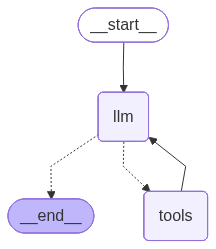

In [113]:
display(Image(app.get_graph().draw_mermaid_png()))

In [115]:
result = app.invoke({"messages": [HumanMessage(content="What is the stock price of TCS.NS?")]})

In [116]:
result

{'messages': [HumanMessage(content='What is the stock price of TCS.NS?', additional_kwargs={}, response_metadata={}, id='1b08f0e1-8466-4d8e-b6a2-5ef3b872b4d0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"ticker": "TCS.NS"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c65a6-bbba-7d42-a974-0ec6c43e21bc-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'TCS.NS'}, 'id': '485b4098-6762-4451-a30b-1f3d412fe8e2', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 365, 'output_tokens': 20, 'total_tokens': 385, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='The last closing price of TCS.NS was ₹2685.80.', name='get_stock_price', id='56281f70-2384-41ab-8138-c4545030675c', tool_call_id='485b4098-6762-4451-a30b-1f3d412fe8e2'),
  AIMessage(content='The last closing pri

In [121]:
for i in result["messages"]:
    i.pretty_print()

================================ Human Message =================================

What is the stock price of TCS.NS?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (485b4098-6762-4451-a30b-1f3d412fe8e2)
 Call ID: 485b4098-6762-4451-a30b-1f3d412fe8e2
  Args:
    ticker: TCS.NS
================================= Tool Message =================================
Name: get_stock_price

The last closing price of TCS.NS was ₹2685.80.
================================== Ai Message ==================================

The last closing price of TCS.NS was ₹2685.80.


In [ ]:
result = app.invoke({"messages": [HumanMessage(content="What was in the latest indian union budget report for the year 2024?")]})

{'messages': [HumanMessage(content='What was in the latest indian union budget report for the year 2024?', additional_kwargs={}, response_metadata={}, id='592d71a8-6ce2-42c1-a12f-863b3dc24110'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "Indian union budget 2024 report"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c65ab-74ee-7873-a1bb-f5bb0f2d00d6-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Indian union budget 2024 report'}, 'id': 'a5558bb6-e05e-4740-9d48-e0da95f5d16a', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 373, 'output_tokens': 21, 'total_tokens': 394, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="Page: 2024 Union budget of India\nSummary: The 2024 Union Budget of India was presented by Finance Minister, Nirmala Sitharaman on 23 July 20

In [127]:
for i in result["messages"]:
    i.pretty_print()

================================ Human Message =================================

What was in the latest indian union budget report for the year 2024?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (a5558bb6-e05e-4740-9d48-e0da95f5d16a)
 Call ID: a5558bb6-e05e-4740-9d48-e0da95f5d16a
  Args:
    query: Indian union budget 2024 report
================================= Tool Message =================================
Name: wikipedia

Page: 2024 Union budget of India
Summary: The 2024 Union Budget of India was presented by Finance Minister, Nirmala Sitharaman on 23 July 2024. This was the first budget of Narendra Modi led NDA government's third term.

Page: 2025 Union budget of India
Summary: The  2025 Union budget of India was presented by Finance Minister Nirmala Sitharaman on 1 February 2025 for the financial year 2025-2026. This was the first full financial year budget of Prime Minister Narendra Modi's third term in offic
========

In [128]:
result = app.invoke({"messages": [HumanMessage(content="What is the latest AI News and multiply 10 and 6")]})

for i in result["messages"]:
    i.pretty_print()

================================ Human Message =================================

What is the latest AI News and multiply 10 and 6
================================== Ai Message ==================================
Tool Calls:
  wikipedia (9d17d29b-468a-4836-b1f9-2593cd029a92)
 Call ID: 9d17d29b-468a-4836-b1f9-2593cd029a92
  Args:
    query: AI News
  multiply (251cd0d5-89e4-48df-990c-b2e2dba22481)
 Call ID: 251cd0d5-89e4-48df-990c-b2e2dba22481
  Args:
    b: 6
    a: 10
================================= Tool Message =================================
Name: wikipedia

Page: Generative artificial intelligence
Summary: Generative artificial intelligence, also known as generative AI or GenAI, is a subfield of artificial intelligence that uses generative models to generate text, images, videos, audio, software code or other forms of data. These models learn the underlying patterns and structures of their training data, and use them to generate new data in response to input, which often takes t